In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from statsmodels.api import OLS
from statsmodels.formula.api import ols

In [2]:
train = pd.read_csv("data/train_merged.csv", parse_dates=["date"])
train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,city,state,type,cluster,transactions,dcoilwtico,work_day,day_off
0,121497040,2017-07-08,46,1366213,2.0,False,HOME AND KITCHEN I,6257,0,Quito,Pichincha,A,14,4328,NaN,False,True
1,121497041,2017-07-08,46,1367273,9.0,False,HOME AND KITCHEN I,6212,0,Quito,Pichincha,A,14,4328,NaN,False,True
2,121497042,2017-07-08,46,1367438,2.0,False,HOME AND KITCHEN II,6330,0,Quito,Pichincha,A,14,4328,NaN,False,True
3,121497043,2017-07-08,46,1368456,1.0,False,HOME AND KITCHEN I,6267,0,Quito,Pichincha,A,14,4328,NaN,False,True
4,121497044,2017-07-08,46,1368488,1.0,False,HOME AND KITCHEN I,6269,0,Quito,Pichincha,A,14,4328,NaN,False,True


In [3]:
train.dtypes

id                       int64
date            datetime64[ns]
store_nbr                int64
item_nbr                 int64
unit_sales             float64
onpromotion               bool
family                  object
class                    int64
perishable               int64
city                    object
state                   object
type                    object
cluster                  int64
transactions             int64
dcoilwtico             float64
work_day                  bool
day_off                   bool
dtype: object

## Select "meaningful" columns
Remove `state`, `city` and `store_nbr` as these are represented by the proxy var `cluster`.
Remove `item_nbr` as this is described roughly by the proxy var `family`

We want to turn the following variables into a factor:
* `family`
* `class`
* `type`
* `cluster`

as well as all of the bool columns.

We need to process the following columns to fill missing values:
* `dcoilwtico`

We ignore `transactions`.
Also ignoring the time-series structure at this point.

Including `id` and `date` at this point too as they are useful for id/further analysis

In [4]:
# check base assumptions - this should be false
(train.work_day & train.day_off).any()

False

In [5]:
factor_cols = ["family", "type", "cluster", "class"]
numer_cols = ["unit_sales", "dcoilwtico"]
bool_cols = ["onpromotion", "perishable", "day_off"]

In [6]:
train[numer_cols].describe()

,unit_sales,dcoilwtico
count,4.000000e+06,2.767654e+06
mean,8.018128e+00,4.775121e+01
std,2.398207e+01,1.647307e+00
min,-2.410000e+02,4.440000e+01
25%,2.000000e+00,4.621000e+01
50%,4.000000e+00,4.777000e+01
75%,8.000000e+00,4.919000e+01
max,7.348000e+03,5.021000e+01


In [7]:
train[factor_cols].nunique()

family      33
type         5
cluster     17
class      322
dtype: int64

Class has too many levels to practically 1-hot encode - what are they? Can they be combined? Are describing the same thing as another column but more granularly? 

In [8]:
(train["class"].astype(str) + train["family"]).nunique()

322

Interesting to note - class is always a subtype of family (ie each level of class only belongs to one level of family)!

What's the mapping? Can we take advantage of it?

In [9]:
for fam in train.family.unique():
    print(f"{fam} has {train[train.family == fam]['class'].nunique()} levels of class")

HOME AND KITCHEN I has 20 levels of class
HOME AND KITCHEN II has 12 levels of class
PERSONAL CARE has 12 levels of class
GROCERY I has 65 levels of class
BEVERAGES has 21 levels of class
CLEANING has 26 levels of class
LIQUOR,WINE,BEER has 16 levels of class
BREAD/BAKERY has 15 levels of class
DAIRY has 22 levels of class
DELI has 13 levels of class
FROZEN FOODS has 11 levels of class
POULTRY has 3 levels of class
HOME CARE has 6 levels of class
PET SUPPLIES has 2 levels of class
PRODUCE has 19 levels of class
PLAYERS AND ELECTRONICS has 1 levels of class
CELEBRATION has 4 levels of class
SCHOOL AND OFFICE SUPPLIES has 6 levels of class
LADIESWEAR has 1 levels of class
AUTOMOTIVE has 5 levels of class
MEATS has 4 levels of class
MAGAZINES has 4 levels of class
EGGS has 3 levels of class
BOOKS has 1 levels of class
LAWN AND GARDEN has 6 levels of class
GROCERY II has 1 levels of class
PREPARED FOODS has 7 levels of class
BEAUTY has 5 levels of class
SEAFOOD has 5 levels of class
HARDWA

So about half of the `family` values should get a decent uplift by including `class`. 

I want to 1-hot encode these, so will ignore both `family` and `class` at this point as they consume too much ram once one-hot encoded

### Fill NAs in dcoilwtico

In [10]:
oil_prices = train.groupby("date").first().dcoilwtico

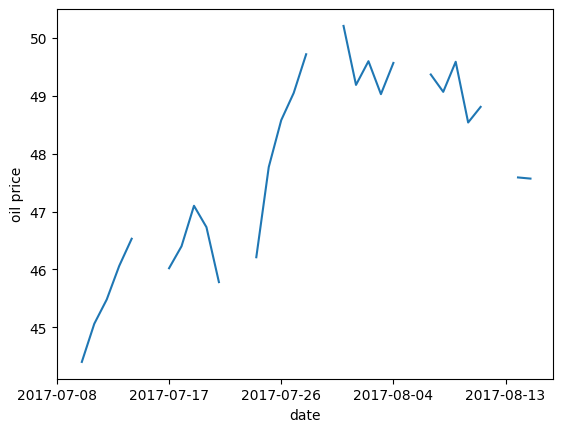

In [11]:
plt.plot(oil_prices.index, oil_prices)
plt.xlabel("date")
plt.ylabel("oil price")
min_date = min(train.date) 
max_bound_date = max(train.date) + timedelta(days=1)
step = timedelta(days=(max_bound_date - min_date).days//4)
plt.xticks(np.arange(min_date, max_bound_date, step))
plt.show()

Visually, looks like linear interpolation should produce a reasonable, if not perfect, result

In [12]:
def lin_interp(n_days, start_val, end_val):
    if n_days > 0:
        diff = end_val - start_val
        step = diff/(n_days+1)
        return [start_val + step * (i+1) for i in range(n_days)]
    else:
        return []

In [13]:
# code like this as all days are present
prices = []
days_na = 0
init_val = oil_prices.iloc[0] if oil_prices.notna().iloc[0] else oil_prices.mean()
for day_price in oil_prices:
    if np.isnan(day_price):
        days_na += 1
    else:
        interp_vals = lin_interp(days_na, init_val, day_price)
        prices.extend(interp_vals)
        prices.append(day_price)
        init_val = day_price
        days_na = 0

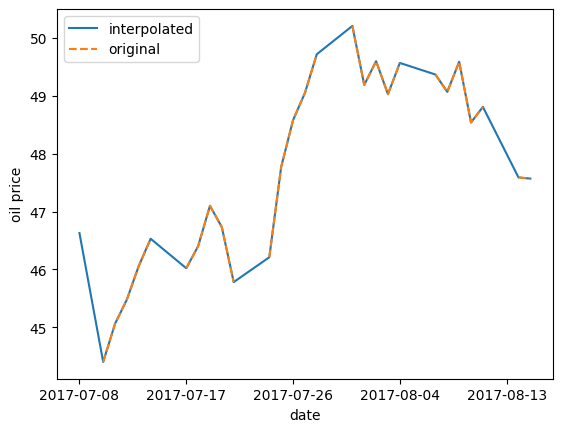

In [14]:
plt.plot(oil_prices.index, prices, label="interpolated")
plt.plot(oil_prices.index, oil_prices, linestyle="--", label="original")
plt.legend()
plt.xlabel("date")
plt.ylabel("oil price")
min_date = min(train.date) 
max_bound_date = max(train.date) + timedelta(days=1)
step = timedelta(days=(max_bound_date - min_date).days//4)
plt.xticks(np.arange(min_date, max_bound_date, step))
plt.show()

In [15]:
oil_price_interp = pd.Series(prices, index=oil_prices.index)

In [16]:
for date in oil_price_interp.index:
    idxs = train[train.date == date].index
    train.loc[idxs, "dcoilwtico"] = oil_price_interp[date]

### Process the columns into a more useful state

In [19]:
# get day number
train["day"] = train.date.dt.dayofweek

In [20]:
factor_cols = ["family", "type", "day"]#, "cluster"]
numer_cols = ["unit_sales", "dcoilwtico"]
bool_cols = ["onpromotion", "perishable", "day_off"]
id_cols = ["id", "date"]  # add item_number and store number here as id cols to allow for exploiting the timeseries nature!
cols = id_cols + factor_cols + numer_cols + bool_cols
train_sub = train[cols]

In [21]:
enc = OneHotEncoder()
enc.fit(train_sub[factor_cols])
factor_col_names = enc.get_feature_names_out()

In [22]:
# process bools into ints
train_sub = train_sub.astype({col: "int" for col in bool_cols})
# factorise factor cols
oh_encoded = enc.transform(train_sub[factor_cols])
train_sub = train_sub.drop(factor_cols, axis=1)
for i in range(oh_encoded.shape[1]):
    train_sub[factor_col_names[i].replace(" ", "_").replace("/", "_").replace(",", "_")] = oh_encoded[:, i].A.flatten()

## Get correlation

In [23]:
# randomly sample rows so that correlation computations are not horrifically expensive
rng = np.random.default_rng(seed=46290)
samp_idxs = rng.choice(train_sub.index, size=int(0.1*train_sub.shape[0]), replace=False)
train_sub_small = train_sub.loc[samp_idxs]

In [24]:
corrs = train_sub_small.drop(id_cols, axis=1).corr()
corrs

,unit_sales,dcoilwtico,onpromotion,perishable,day_off,family_AUTOMOTIVE,family_BABY_CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,...,type_C,type_D,type_E,day_0,day_1,day_2,day_3,day_4,day_5,day_6
unit_sales,1.000000,0.007057,0.105762,0.052925,0.027453,-0.013365,-0.002116,-0.009775,0.067455,-0.000948,...,-0.040732,-0.034708,-0.007257,-0.005720,-0.010452,-0.002132,-0.018244,-0.003524,0.012030,0.025705
dcoilwtico,0.007057,1.000000,-0.028620,0.002669,0.022272,0.000471,0.001549,0.000034,-0.005366,0.002144,...,0.001529,0.000789,0.000093,-0.115159,-0.052992,0.077174,0.032461,0.082063,0.053868,-0.058903
onpromotion,0.105762,-0.028620,1.000000,0.126293,-0.033447,-0.016705,-0.002758,0.011798,-0.033976,-0.001126,...,0.038904,-0.032617,0.014978,-0.029184,-0.001328,0.074494,-0.028314,0.039176,-0.032530,-0.016761
perishable,0.052925,0.002669,0.126293,1.000000,-0.007289,-0.028396,-0.004554,-0.022403,-0.255485,-0.001859,...,-0.052115,0.049781,-0.005120,-0.001701,0.001641,0.003199,0.005397,0.001978,-0.004682,-0.004966
day_off,0.027453,0.022272,-0.033447,-0.007289,1.000000,0.007206,-0.002178,0.002606,0.001390,-0.000611,...,-0.001791,-0.010266,0.010041,-0.289946,-0.285731,-0.275471,-0.270547,-0.113292,0.567019,0.617137
family_AUTOMOTIVE,-0.013365,0.000471,-0.016705,-0.028396,0.007206,1.000000,-0.000374,-0.001841,-0.020990,-0.000153,...,0.003019,-0.005303,-0.004164,-0.004696,-0.002238,-0.000582,-0.000640,-0.000754,0.003682,0.005077
family_BABY_CARE,-0.002116,0.001549,-0.002758,-0.004554,-0.002178,-0.000374,1.000000,-0.000295,-0.003366,-0.000024,...,0.000171,0.000335,0.001654,0.001100,0.002054,-0.001027,0.001014,0.000849,-0.002243,-0.001705
family_BEAUTY,-0.009775,0.000034,0.011798,-0.022403,0.002606,-0.001841,-0.000295,1.000000,-0.016560,-0.000121,...,-0.005214,0.001440,-0.002523,0.000019,-0.000082,-0.002950,-0.001134,0.000135,0.002636,0.001109
family_BEVERAGES,0.067455,-0.005366,-0.033976,-0.255485,0.001390,-0.020990,-0.003366,-0.016560,1.000000,-0.001374,...,0.008680,-0.008361,0.003734,0.000963,-0.001953,-0.001334,0.000323,-0.000371,0.000755,0.001494
family_BOOKS,-0.000948,0.002144,-0.001126,-0.001859,-0.000611,-0.000153,-0.000024,-0.000121,-0.001374,1.000000,...,-0.001579,0.002616,-0.000870,0.000811,-0.001350,0.001161,0.001215,-0.001222,0.000966,-0.001406


In [25]:
# which cols are correlated with unit_sales (target) most strongly?
corrs["unit_sales"].sort_values(ascending=False)[:10]

unit_sales          1.000000
onpromotion         0.105762
family_PRODUCE      0.095506
type_A              0.087631
family_BEVERAGES    0.067455
perishable          0.052925
family_POULTRY      0.032415
day_off             0.027453
day_6               0.025705
family_MEATS        0.020379
Name: unit_sales, dtype: float64

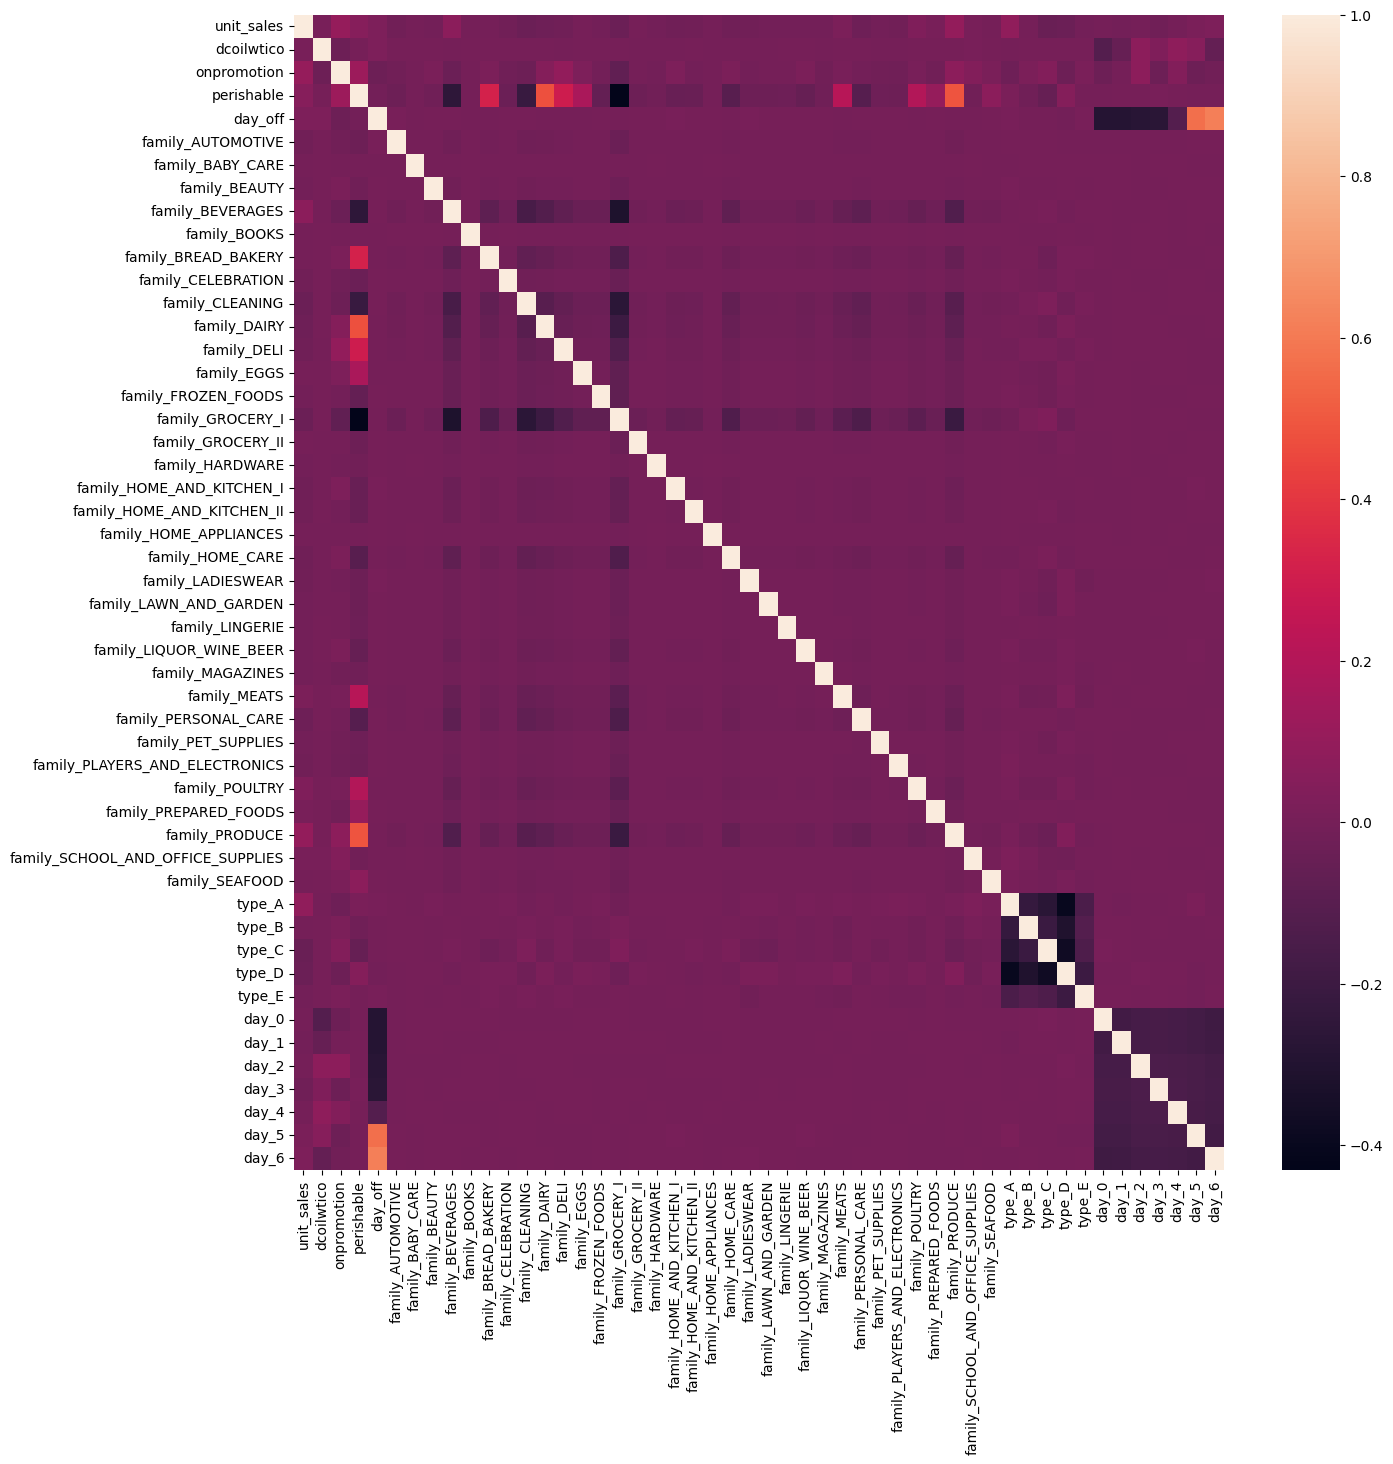

In [26]:
plt.figure(figsize=(15,15))
sns.heatmap(corrs)
plt.show()

Interesting that the `type` factors are all (comparatively) highly correlated with each other, and are all negatively correlated

Also - perishable is otherwise the most correlated column, can probably reduce the input size by including it!

In [27]:
# quick OLS regression  - too many variables at this point!
model = OLS(train_sub_small.unit_sales, train_sub_small[corrs["unit_sales"].sort_values(ascending=False)[1:11].index])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             unit_sales   R-squared (uncentered):                   0.129
Model:                            OLS   Adj. R-squared (uncentered):              0.129
Method:                 Least Squares   F-statistic:                              5932.
Date:                Wed, 08 May 2024   Prob (F-statistic):                        0.00
Time:                        21:17:23   Log-Likelihood:                     -1.8255e+06
No. Observations:              400000   AIC:                                  3.651e+06
Df Residuals:                  399990   BIC:                                  3.651e+06
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
onpromotion          9.2849      0.115     80.802      0.000       9.060       9.510
family_PRODUCE       8.9454      0.163     54.897      0.000       8.626       9.265
type_A               6.8501      0.083     82.654      0.000       6.688       7.013
family_BEVERAGES     8.0748      0.096     83.834      0.000       7.886       8.264
perishable           2.2023      0.100     22.024      0.000       2.006       2.398
family_POULTRY       8.0120      0.328     24.425      0.000       7.369       8.655
day_off              2.1863      0.202     10.806      0.000       1.790       2.583
day_6                2.0735      0.220      9.439      0.000       1.643       2.504
family_MEATS         5.4098      0.308     17.582      0.000       4.807       6.013
day_5                1.3527      0.223      6.078      0.000       0.916       1.789
==============================================================================
Omnibus:                  1249512.826   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     434362670710.897
Skew:                          48.647   Prob(JB):                         0.00
Kurtosis:                    5107.145   Cond. No.                         7.43
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Surprisingly well conditioned! 


TODO: 
* [X] Remove missing values from oil price data
* [ ] Exploit time-series structure with some (plotting) analysis
* [X] Detect multicolinearity

In [28]:
VIF = 1/(1-corrs**2)
for i in range(VIF.shape[0]):
    for j in range(VIF.shape[1]):
        if np.isfinite(VIF.iloc[i,j]) and VIF.iloc[i,j] > 1.5:
            print(f"High VIF for {VIF.index[i], VIF.columns[j]} of {VIF.iloc[i,j]}")

High VIF for ('day_off', 'day_6') of 1.61513972253282
High VIF for ('day_6', 'day_off') of 1.61513972253282


The main potential for multicolinearity here appears to be between the pairs (`cluster_6`, `type_B`) and  (`cluster_10`, `type_B`). Remove one of these (cluster?) and try again (these had VIF over 3, so I removed the whole `cluster` column. That's why the values aren't printed above)

Also drop `day_6` and `day_5` as these are effectively aliases of `day_off`

In [67]:
model = OLS(train_sub_small.unit_sales, train_sub_small[corrs["unit_sales"].drop(["day_5", "day_6"]).sort_values(ascending=False)[1:11].index])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             unit_sales   R-squared (uncentered):                   0.129
Model:                            OLS   Adj. R-squared (uncentered):              0.129
Method:                 Least Squares   F-statistic:                              5936.
Date:                Wed, 08 May 2024   Prob (F-statistic):                        0.00
Time:                        21:51:24   Log-Likelihood:                     -1.8255e+06
No. Observations:              400000   AIC:                                  3.651e+06
Df Residuals:                  399990   BIC:                                  3.651e+06
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
onpromotion                           9.2895      0.115     80.745      0.000       9.064       9.515
family_PRODUCE                        9.1068      0.164     55.670      0.000       8.786       9.427
type_A                                6.8386      0.083     82.483      0.000       6.676       7.001
family_BEVERAGES                      8.0795      0.096     83.879      0.000       7.891       8.268
perishable                            2.0434      0.101     20.202      0.000       1.845       2.242
family_POULTRY                        8.1769      0.328     24.904      0.000       7.533       8.820
day_off                               3.7500      0.069     54.258      0.000       3.614       3.885
family_MEATS                          5.5691      0.308     18.081      0.000       4.965       6.173
family_PREPARED_FOODS                 6.9025      0.627     11.018      0.000       5.675       8.130
family_SCHOOL_AND_OFFICE_SUPPLIES     5.4077      1.286      4.205      0.000       2.887       7.929
==============================================================================
Omnibus:                  1249575.110   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     434518466887.276
Skew:                          48.654   Prob(JB):                         0.00
Kurtosis:                    5108.060   Cond. No.                         24.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
all_names = corrs['unit_sales'].sort_values(ascending=False).drop(["day_5", "day_6"])[1:].index

In [47]:
# model with intercept
model = ols(f"unit_sales ~ {' + '.join(all_names)}", data=train_sub_small)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             unit_sales   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     380.1
Date:                Wed, 08 May 2024   Prob (F-statistic):               0.00
Time:                        21:27:18   Log-Likelihood:            -1.8228e+06
No. Observations:              400000   AIC:                         3.646e+06
Df Residuals:                  399955   BIC:                         3.646e+06
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -2.7566      0.972     -2.837      0.005      -4.661      -0.852
onpromotion                           7.9868      0.118     67.790      0.000       7.756       8.218
family_PRODUCE                        6.2135      0.182     34.223      0.000       5.858       6.569
type_A                                3.3761      0.206     16.363      0.000       2.972       3.780
family_BEVERAGES                      7.4643      0.530     14.085      0.000       6.426       8.503
perishable                            4.4495      0.486      9.152      0.000       3.497       5.402
family_POULTRY                        5.2586      0.311     16.898      0.000       4.649       5.869
day_off                              -0.2372      0.218     -1.088      0.276      -0.664       0.190
family_MEATS                          2.6400      0.294      8.968      0.000       2.063       3.217
family_PREPARED_FOODS                 3.7964      0.567      6.696      0.000       2.685       4.908
family_SCHOOL_AND_OFFICE_SUPPLIES     5.7924      1.334      4.343      0.000       3.179       8.406
dcoilwtico                            0.1731      0.022      7.766      0.000       0.129       0.217
family_EGGS                          -0.5497      0.351     -1.568      0.117      -1.237       0.138
family_GROCERY_II                     3.3057      0.894      3.698      0.000       1.554       5.057
family_BOOKS                         -2.7660     11.086     -0.249      0.803     -24.495      18.963
family_BREAD_BAKERY                  -1.4566      0.223     -6.525      0.000      -1.894      -1.019
family_BABY_CARE                     -0.6801      4.551     -0.149      0.881      -9.600       8.240
day_2                                -2.1127      0.250     -8.445      0.000      -2.603      -1.622
family_SEAFOOD                       -3.5654      0.815     -4.375      0.000      -5.163      -1.968
family_HOME_APPLIANCES               -2.8202      3.585     -0.787      0.431      -9.846       4.206
day_4                                -1.9378      0.212     -9.132      0.000      -2.354      -1.522
type_B                               -0.8186      0.212     -3.863      0.000      -1.234      -0.403
day_0                                -1.4559      0.241     -6.044      0.000      -1.928      -0.984
family_HARDWARE                      -2.1837      1.612     -1.355      0.175      -5.343       0.975
family_FROZEN_FOODS                   1.9643      0.629      3.121      0.002       0.731       3.198
type_E                               -1.2009      0.228     -5.276      0.000      -1.647      -0.755
family_LIQUOR_WINE_BEER               0.8642      0.659      1.312      0.189      -0.427       2.155
family_MAGAZINES       

Unsurprisingly, the above is poorly conditioned. As we have a silly number of samples, anything with probability above $0.000$ is probably not statistically significant. So we remove these cols and form a new master model 

In [55]:
def prune_model(model_results, names, intercept=True):
    t_test_res = model_results._results.pvalues
    stat_sig_idxs = np.where(np.round(t_test_res, decimals=3) == 0)[0]
    idxs = np.where(stat_sig_idxs > 0)[0]-1  # -1 to account for intercept being index 0
    labels_keep = [names[i] for i in idxs]
    keep_intercept = intercept and (0 in stat_sig_idxs)
    model_reduced = ols(f"unit_sales ~ {' + '.join(labels_keep)}{'-1' if not keep_intercept else ''}", data=train_sub_small)
    results_reduced = model_reduced.fit()
    return model_reduced, results_reduced, labels_keep, keep_intercept

In [56]:
model_red, results_red, red_names, intercept_present = prune_model(results, all_names)
results_red.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             unit_sales   R-squared (uncentered):                   0.139
Model:                            OLS   Adj. R-squared (uncentered):              0.139
Method:                 Least Squares   F-statistic:                              2391.
Date:                Wed, 08 May 2024   Prob (F-statistic):                        0.00
Time:                        21:35:53   Log-Likelihood:                     -1.8232e+06
No. Observations:              400000   AIC:                                  3.647e+06
Df Residuals:                  399973   BIC:                                  3.647e+06
Df Model:                          27                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
type_C                               -0.8324      0.103     -8.118      0.000      -1.033      -0.631
onpromotion                           7.8892      0.117     67.182      0.000       7.659       8.119
family_PRODUCE                        9.8725      0.175     56.413      0.000       9.529      10.215
type_A                                4.9670      0.098     50.573      0.000       4.775       5.160
family_BEVERAGES                      5.5767      0.104     53.792      0.000       5.374       5.780
perishable                           -1.0815      0.125     -8.625      0.000      -1.327      -0.836
family_POULTRY                        8.9151      0.333     26.783      0.000       8.263       9.567
day_off                               1.5756      0.088     17.806      0.000       1.402       1.749
family_MEATS                          6.2905      0.313     20.090      0.000       5.677       6.904
family_PREPARED_FOODS                 7.4037      0.626     11.820      0.000       6.176       8.631
family_SCHOOL_AND_OFFICE_SUPPLIES     3.9972      1.279      3.125      0.002       1.490       6.505
dcoilwtico                            0.0792      0.002     41.979      0.000       0.076       0.083
family_EGGS                           3.1019      0.379      8.189      0.000       2.360       3.844
family_GROCERY_II                     1.4255      0.757      1.882      0.060      -0.059       2.910
family_BOOKS                         -4.6037     11.543     -0.399      0.690     -27.227      18.019
family_BREAD_BAKERY                   2.1925      0.228      9.632      0.000       1.746       2.639
family_BABY_CARE                     -2.6717      4.713     -0.567      0.571     -11.908       6.565
day_2                                -0.0741      0.123     -0.603      0.546      -0.315       0.167
family_SEAFOOD                        0.0916      0.907      0.101      0.920      -1.685       1.869
family_HOME_APPLIANCES               -4.9105      3.697     -1.328      0.184     -12.156       2.335
day_4                                -0.2707      0.116     -2.332      0.020      -0.498      -0.043
type_B                                0.8144      0.113      7.223      0.000       0.593       1.035
day_0                                 0.4605      0.113      4.082      0.000       0.239       0.682
family_HARDWARE                      -4.0612      1.590     -2.554      0.011      -7.178      -0.945
family_FROZEN_FOODS                   0.0894      0.369      0.243      0.808      -0.633       0.812
type_E                                0.4090      0.151      2.713      0.007       0.114       0.705
family_LIQUOR_WINE_BEER   

In [57]:
model_red, results_red, red_names, intercept_present = prune_model(results_red, all_names, intercept_present)
results_red.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             unit_sales   R-squared (uncentered):                   0.138
Model:                            OLS   Adj. R-squared (uncentered):              0.138
Method:                 Least Squares   F-statistic:                              4585.
Date:                Wed, 08 May 2024   Prob (F-statistic):                        0.00
Time:                        21:36:14   Log-Likelihood:                     -1.8234e+06
No. Observations:              400000   AIC:                                  3.647e+06
Df Residuals:                  399986   BIC:                                  3.647e+06
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
onpromotion                           7.8001      0.117     66.803      0.000       7.571       8.029
family_PRODUCE                        9.3123      0.165     56.509      0.000       8.989       9.635
type_A                                4.9831      0.087     57.048      0.000       4.812       5.154
family_BEVERAGES                      5.5985      0.103     54.171      0.000       5.396       5.801
perishable                           -0.4721      0.110     -4.286      0.000      -0.688      -0.256
family_POULTRY                        8.3301      0.328     25.423      0.000       7.688       8.972
day_off                               1.5099      0.077     19.595      0.000       1.359       1.661
family_MEATS                          5.7012      0.308     18.540      0.000       5.099       6.304
family_PREPARED_FOODS                 6.8249      0.624     10.941      0.000       5.602       8.048
family_SCHOOL_AND_OFFICE_SUPPLIES     4.2501      1.280      3.321      0.001       1.742       6.758
dcoilwtico                            0.0795      0.001     64.250      0.000       0.077       0.082
family_EGGS                           2.5441      0.374      6.797      0.000       1.810       3.278
family_GROCERY_II                     1.4679      0.758      1.938      0.053      -0.017       2.953
family_BOOKS                         -4.5087     11.547     -0.390      0.696     -27.141      18.123
==============================================================================
Omnibus:                  1255696.150   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     448787695763.631
Skew:                          49.339   Prob(JB):                         0.00
Kurtosis:                    5191.210   Cond. No.                     1.51e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [58]:
# repeat again, still ill-conditioned and candidate labels to remove
model_red, results_red, red_names, intercept_present = prune_model(results_red, all_names, intercept_present)
results_red.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             unit_sales   R-squared (uncentered):                   0.129
Model:                            OLS   Adj. R-squared (uncentered):              0.129
Method:                 Least Squares   F-statistic:                              5936.
Date:                Wed, 08 May 2024   Prob (F-statistic):                        0.00
Time:                        21:36:30   Log-Likelihood:                     -1.8255e+06
No. Observations:              400000   AIC:                                  3.651e+06
Df Residuals:                  399990   BIC:                                  3.651e+06
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
onpromotion                           9.2895      0.115     80.745      0.000       9.064       9.515
family_PRODUCE                        9.1068      0.164     55.670      0.000       8.786       9.427
type_A                                6.8386      0.083     82.483      0.000       6.676       7.001
family_BEVERAGES                      8.0795      0.096     83.879      0.000       7.891       8.268
perishable                            2.0434      0.101     20.202      0.000       1.845       2.242
family_POULTRY                        8.1769      0.328     24.904      0.000       7.533       8.820
day_off                               3.7500      0.069     54.258      0.000       3.614       3.885
family_MEATS                          5.5691      0.308     18.081      0.000       4.965       6.173
family_PREPARED_FOODS                 6.9025      0.627     11.018      0.000       5.675       8.130
family_SCHOOL_AND_OFFICE_SUPPLIES     5.4077      1.286      4.205      0.000       2.887       7.929
==============================================================================
Omnibus:                  1249575.110   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     434518466887.276
Skew:                          48.654   Prob(JB):                         0.00
Kurtosis:                    5108.060   Cond. No.                         24.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
# normalise the coeffs for interpretability - as are all positive, this is simple enough :)
coeffs = results_red._results.params
coeffs_norm = coeffs/coeffs.sum()
pd.Series(coeffs_norm, index=red_names).sort_values(ascending=False)

onpromotion                          0.142555
family_PRODUCE                       0.139753
family_POULTRY                       0.125482
family_BEVERAGES                     0.123987
family_PREPARED_FOODS                0.105925
type_A                               0.104944
family_MEATS                         0.085463
family_SCHOOL_AND_OFFICE_SUPPLIES    0.082987
day_off                              0.057546
perishable                           0.031358
dtype: float64

Leaving the model here as we can't improve simply by pruning it at this point and it's well conditioned (even if a low $R^2$ value). However, some notes:
* The coefficients are all *way* higher than expected - probably due to no intercept
* Poultry, produce, prepared foods, meats and beverages are clearly top sellers. Not particularly controversial
* Surprised that school and office supplies are such high sellers (according to the model)
* Perishable is surprisingly significant, despite only accounting for ~3% of the value of sales according to this model
* People buy more on days off work
* type A products sell more - whatever type A means
* Interesting that by pruning the model, we've ended up selecting the 10 most highly correlated variables again...

Inspecting the outputs, I think the pruning function over-pruned the model. So I'm pruning the model manually below

In [71]:
# the above seems to have over-pruned? manually prune based on previous output
cols = [
    "family_PRODUCE", "type_A", "family_BEVERAGES", "perishable", "family_POULTRY", 
    "day_off", "family_MEATS", "family_PREPARED_FOODS", "dcoilwtico", "family_EGGS"
]
model = ols(f"unit_sales ~  {'+'.join(cols)} - 1", data=train_sub_small)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             unit_sales   R-squared (uncentered):                   0.129
Model:                            OLS   Adj. R-squared (uncentered):              0.129
Method:                 Least Squares   F-statistic:                              5902.
Date:                Wed, 08 May 2024   Prob (F-statistic):                        0.00
Time:                        22:01:58   Log-Likelihood:                     -1.8256e+06
No. Observations:              400000   AIC:                                  3.651e+06
Df Residuals:                  399990   BIC:                                  3.651e+06
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
family_PRODUCE            9.3862      0.166     56.641      0.000       9.061       9.711
type_A                    4.8259      0.088     54.983      0.000       4.654       4.998
family_BEVERAGES          5.5805      0.104     53.726      0.000       5.377       5.784
perishable                0.2750      0.110      2.498      0.012       0.059       0.491
family_POULTRY            7.9475      0.329     24.123      0.000       7.302       8.593
day_off                   1.3461      0.077     17.381      0.000       1.194       1.498
family_MEATS              5.2810      0.309     17.081      0.000       4.675       5.887
family_PREPARED_FOODS     5.5723      0.627      8.887      0.000       4.343       6.801
dcoilwtico                0.0961      0.001     78.939      0.000       0.094       0.099
family_EGGS               2.5090      0.376      6.666      0.000       1.771       3.247
==============================================================================
Omnibus:                  1253172.000   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     438422295157.298
Skew:                          49.062   Prob(JB):                         0.00
Kurtosis:                    5130.934   Cond. No.                         818.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Notes:
* Perishable is not as statistically significant in this model, which intuitively makes sense
* Oil prices have a very statistically significant role, despite only contributing a small amount - very interesting to observe
* This model has a similar $R^2$ value than the previous one, but a noticably higher condition number - interesting

In [78]:
signif = results._results.tvalues
coeffs_norm = coeffs/coeffs.sum()
pd.Series(signif, index=cols).sort_values(ascending=False)

dcoilwtico               78.938693
family_PRODUCE           56.641443
type_A                   54.982996
family_BEVERAGES         53.726082
family_POULTRY           24.123393
day_off                  17.380646
family_MEATS             17.080875
family_PREPARED_FOODS     8.887089
family_EGGS               6.666172
perishable                2.497842
dtype: float64

### Run a RandomForest regressor to see how well the feature importances line up with this

In [81]:
seed = 937590723  # smash the numpad
regr = RandomForestRegressor(random_state=seed)
regr.fit(X=train_sub_small[cols], y=train_sub_small.unit_sales)
regr.score(X=train_sub_small[cols], y=train_sub_small.unit_sales)

0.03420882241273626

This fits worse than the linear regressor! Let's see the feature importances anyway

In [87]:
pd.Series(regr.feature_importances_, index = cols).sort_values(ascending=False)

type_A                   0.257266
family_PRODUCE           0.253406
family_BEVERAGES         0.177354
dcoilwtico               0.171688
family_POULTRY           0.051040
day_off                  0.047052
family_MEATS             0.026844
family_PREPARED_FOODS    0.007557
family_EGGS              0.004438
perishable               0.003355
dtype: float64

Interesting results.... Not totally divorced from the above though